# EAS503 Final Presentation
#### Presented by Sean Grzenda, Nicholas Cruz, Shaivi Pandey, and Vidya Lakshmi Ramani 


## Buffalo Crime Incidents Dataset
We will be working with the City of Buffalo's [Crime Incident Dataset](https://data.buffalony.gov/Public-Safety/Crime-Incidents/d6g9-xbgu/about_data), provided by the Buffalo Police Department in CSV format. This dataset gets updated daily and contains crime reports dating back to 1910. 

Our goal is to create and explore a model that predicts the type of crime based on location and time features from 2023. An effective model will allow us to determine which crimes are most popular in a given area at a given time. When used responsibly and ethically, these models can guide decisions related to crime prevention, safety awareness, and resource allocation.

## Database Normalization
- Load the CSV data into a non-normalized database. 
- Normalize database to Third Normal Form. 
- Main normalized table is **Incidents**, which contains the incident ID followed by foreign keys to relevant columns in other tables.

### Non-Normalized Database
In this step, we parse through each line in the CSV file and insert all completely non-null rows into the **Incidents** table. This table contains the following columns:

`Incident_ID`: Unique ID number of incident

`Incident_Datetime`: Exact timestamp

`Incident_Type`: Type of incident

`Incident_Hour`: Hour of the day

`Incident_Day`: Day of the week

`Location`: Latitude and longitude

`Neighborhood`: Neighborhood of incident

`ZIP_Code`: ZIP code of incident

In [1]:
%run create_non_normalized.py

### Normalized Database
In this step, we normalize the database to Third Normal Form. This form is achieved by decomposing the non-normalized **Incidents** table into smaller tables:

- **Incident_Type.** This table contains the primary key `Incident_Type`, listing all unique incident types. We grouped together redundant classes. 
- **ZIP_Code.** This table contains primary key `Zip_Code`, listing all unique ZIP codes.
- **Neighborhood.** This table contains the primary key `Neighborhood`, listing all unique neighborhood names.
- **Location.** This table contains the primary key `Location_ID`, which maps to `Latitude`, `Longitude`, and foreign key `ZIP_Code`.
- **Incidents.** This table contains primary key `Incident_ID`, a timestamp `Datetime`, foreign key `Incident_Type`, foreign key `Location_ID`, and foreign key `Neighborhood`.

In [2]:
%run database_main.py

## Creating Dataframe from Database

In [11]:
import pandas as pd
import numpy as np
import sqlite3
from db_functions import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_recall_fscore_support,classification_report

In [23]:
normalized_db_filename = "normalized.db"
non_normalized_db_filename = "non_normalized.db"
normalized_conn = create_connection(normalized_db_filename)
non_normalized_conn = create_connection(non_normalized_db_filename)

get_incidents_sql = """
    SELECT
        CAST(strftime('%Y', Datetime) AS INTEGER) Year,
        CAST(strftime('%m', Datetime) AS INTEGER) Month,
        CAST(strftime('%d', Datetime) AS INTEGER) Day,
        CAST(strftime('%w', Datetime) AS INTEGER) WeekDay,
        CAST(strftime('%H', Datetime) AS INTEGER) Hour,
        Neighborhood,
        Latitude,
        Longitude,
        Zip_Code,
        Incident_Type
    FROM
        Incidents
        INNER JOIN Location ON Location.Location_ID = Incidents.Location_ID
"""

df = pd.read_sql_query(get_incidents_sql, normalized_conn)
df.head()

,Year,Month,Day,WeekDay,Hour,Neighborhood,Latitude,Longitude,Zip_Code,Incident_Type
0,2010,12,31,5,17,Kaisertown,-78.801,42.872,14206,ROBBERY
1,2022,12,20,2,3,Seneca Babcock,-78.820,42.872,14206,ASSAULT
2,2021,11,29,1,10,North Park,-78.868,42.947,14216,LARCENY/THEFT
3,2010,5,8,6,16,Central,-78.878,42.887,14202,ASSAULT
4,2009,9,1,2,22,Lower West Side,-78.883,42.892,14201,ROBBERY


## Data Summary

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295332 entries, 0 to 295331
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           295332 non-null  int64  
 1   Month          295332 non-null  int64  
 2   Day            295332 non-null  int64  
 3   WeekDay        295332 non-null  int64  
 4   Hour           295332 non-null  int64  
 5   Neighborhood   295332 non-null  object 
 6   Latitude       295332 non-null  float64
 7   Longitude      295332 non-null  float64
 8   Zip_Code       295332 non-null  object 
 9   Incident_Type  295332 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 22.5+ MB


In [22]:
print(df['Incident_Type'].unique())

['ROBBERY' 'ASSAULT' 'LARCENY/THEFT' 'BURGLARY' 'UUV' 'RAPE'
 'SEXUAL ABUSE' 'THEFT OF SERVICES' 'MURDER']


In [28]:
get_unique_incidents_count = """
SELECT
    Incident_Type,
    COUNT(Incident_Type) Type_Count
FROM 
    Incidents
GROUP BY Incident_Type
"""
non_normal_df = pd.read_sql_query(get_unique_incidents_count, non_normalized_conn)
display(non_normal_df)

,Incident_Type,Type_Count
0,AGG ASSAULT ON P/OFFICER,9
1,AGGR ASSAULT,120
2,ASSAULT,59520
3,Assault,114
4,BURGLARY,54618
5,Breaking & Entering,83
6,CRIM NEGLIGENT HOMICIDE,70
7,Homicide,1
8,LARCENY/THEFT,126548
9,MANSLAUGHTER,15


In [7]:
df.describe()

,Year,Month,Day,WeekDay,Hour,Latitude,Longitude
count,295332.000000,295332.000000,295332.000000,295332.000000,295332.000000,295332.000000,295332.000000
mean,2013.501585,6.806811,15.658036,3.045542,11.821503,-78.849818,42.911668
std,5.001358,3.290087,8.885851,2.011255,7.432234,0.031288,0.028286
min,1910.000000,1.000000,1.000000,0.000000,0.000000,-78.910000,42.828000
25%,2009.000000,4.000000,8.000000,1.000000,5.000000,-78.878000,42.893000
50%,2013.000000,7.000000,16.000000,3.000000,13.000000,-78.849000,42.913000
75%,2017.000000,10.000000,23.000000,5.000000,18.000000,-78.821000,42.935000
max,2023.000000,12.000000,31.000000,6.000000,23.000000,-78.799000,42.966000


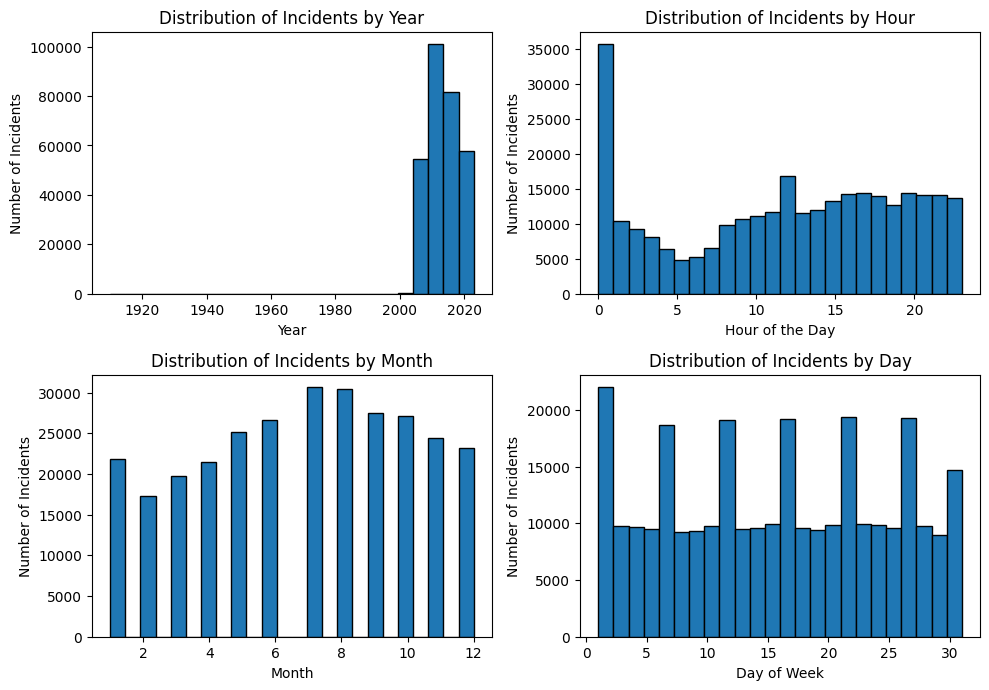

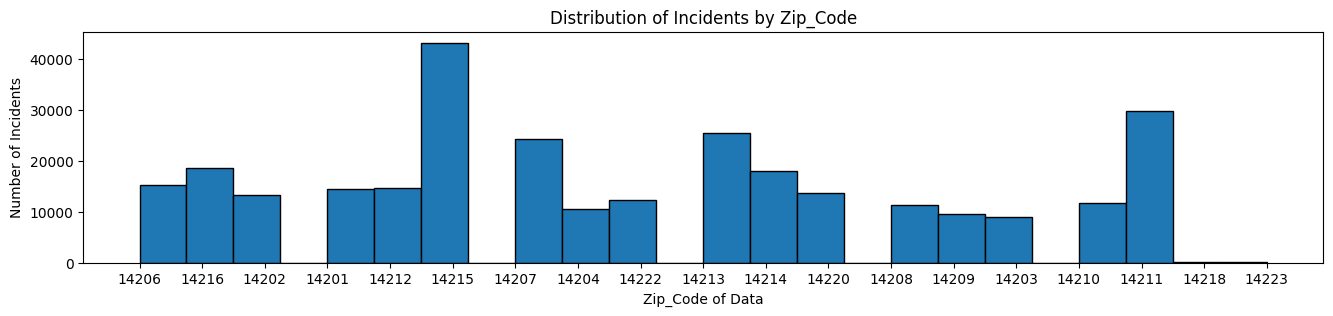

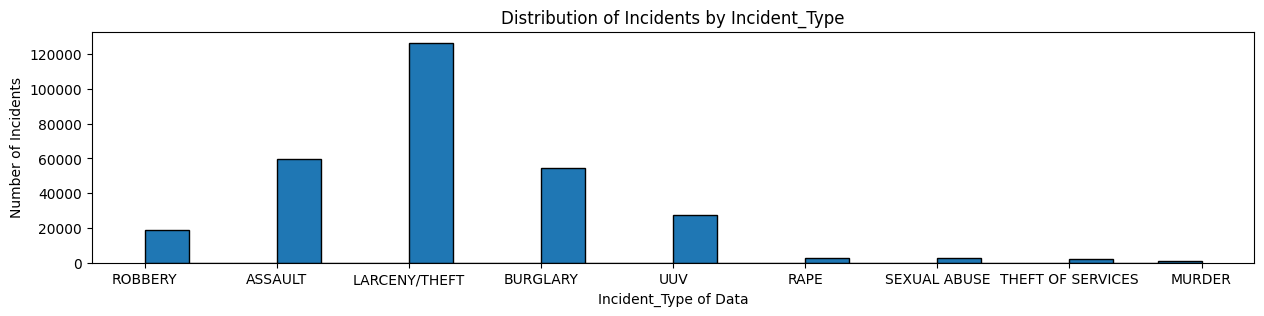

In [8]:
plt.figure(figsize=(10,10))

# Create a histogram for the 'Year' column
plt.subplot(3,2,1)
plt.hist(df['Year'], bins=24, edgecolor='black')
plt.title('Distribution of Incidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')

# Create a histogram for the 'Hour' column
plt.subplot(3,2,2)
plt.hist(df['Hour'], bins=24, edgecolor='black')
plt.title('Distribution of Incidents by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')

# Create a histogram for the 'Month' column
plt.subplot(3,2,3)
plt.hist(df['Month'], bins=24, edgecolor='black')
plt.title('Distribution of Incidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')

# Create a histogram for the 'Day' column
plt.subplot(3,2,4)
plt.hist(df['Day'], bins=24, edgecolor='black')
plt.title('Distribution of Incidents by Day')
plt.xlabel('Day of Week')
plt.ylabel('Number of Incidents')

plt.tight_layout()

# Create a histogram for the 'Zip_Code' column
plt.figure(figsize=(16,3))
plt.hist(df['Zip_Code'], bins=24, edgecolor='black')
plt.title('Distribution of Incidents by Zip_Code')
plt.xlabel('Zip_Code of Data')
plt.ylabel('Number of Incidents')
plt.show()

# Create a histogram for the 'Incident_Type' column
plt.figure(figsize=(15,3))
plt.hist(df['Incident_Type'], bins=24, edgecolor='black')
plt.title('Distribution of Incidents by Incident_Type')
plt.xlabel('Incident_Type of Data')
plt.ylabel('Number of Incidents')
plt.show()

## Random Forest
Random Forest is an ensemble method that attempts to correct the overfitting of a single decision tree. The model achieves this by training each decision tree on randomly selected predictors and samples.

In [9]:
df_2023=df[df['Year']==2023] # get only 2023 data
df_2023.head()

,Year,Month,Day,WeekDay,Hour,Neighborhood,Latitude,Longitude,Zip_Code,Incident_Type
15,2023,5,15,1,22,South Park,-78.822,42.843,14220,ASSAULT
31,2023,1,6,5,20,Hamlin Park,-78.847,42.916,14208,LARCENY/THEFT
143,2023,4,2,0,14,Schiller Park,-78.805,42.907,14211,UUV
156,2023,4,8,6,3,Schiller Park,-78.804,42.917,14211,RAPE
187,2023,5,23,2,7,North Park,-78.862,42.944,14216,BURGLARY


### Find Best `n_estimators` (5-Fold Cross-Validation)

In [10]:
# split into predictors X and response y
X=df_2023[['Month','Day','WeekDay','Hour','Latitude','Longitude','Neighborhood','Zip_Code']]
X=pd.get_dummies(X) # one-hot encode categorical variables
y=np.array(df_2023[['Incident_Type']]).ravel()

scores = {}

n_values=range(1,101,10)

# perform 5-fold cross validation on increasing n_trees
for n in n_values:
    rf = RandomForestClassifier(n_estimators=n,random_state=42)
    score = cross_val_score(rf, X, y, cv=5)
    scores[n]=np.mean(score)

The best model uses 81 trees.


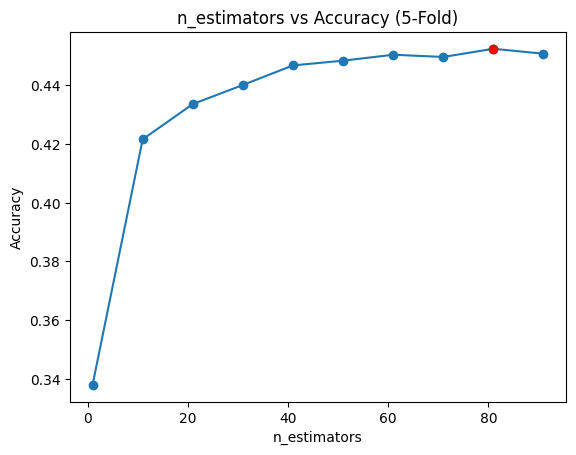

In [13]:
plt.plot(scores.keys(),scores.values(),'o-') 
plt.plot(max(scores, key=scores.get),max(scores.values()),'o',color='r') # plot max
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('n_estimators vs Accuracy (5-Fold)')

print(f'The best model uses {max(scores, key=scores.get)} trees.')

### Train Model with `n_estimators` = 81

In [14]:
# split into predictors X and response y
X=df_2023[['Month','Day','WeekDay','Hour','Latitude','Longitude','Neighborhood','Zip_Code']]
X=pd.get_dummies(X) # one-hot encode categorical variables
y=df_2023['Incident_Type']

# 80/20 train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# create model
rf = RandomForestClassifier(n_estimators=81,random_state=42)
rf.fit(X_train,y_train)

# get prediction
pred = rf.predict(X_test)

### Feature Importance

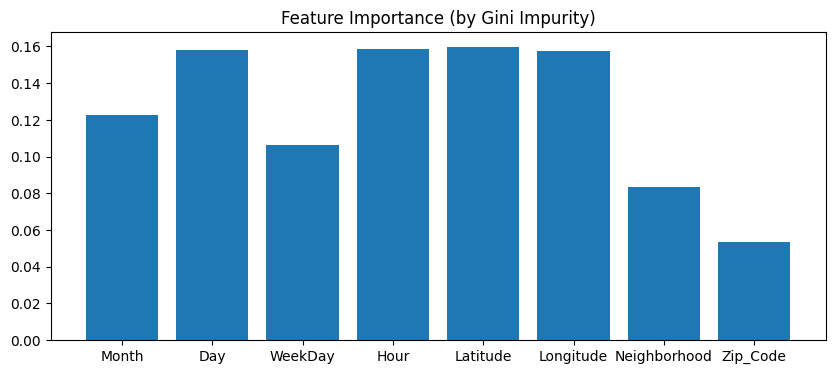

In [15]:
importances=rf.feature_importances_
importances_dict=dict(zip(rf.feature_names_in_,importances)) # encoded feature importance
importances_dict_compressed={} # decoded feature importance
for key,value in importances_dict.items():
    if 'Neighborhood' in key:
        importances_dict_compressed['Neighborhood']=importances_dict_compressed.get('Neighborhood',0)+value
    elif 'Zip_Code' in key:
        importances_dict_compressed['Zip_Code']=importances_dict_compressed.get('Zip_Code',0)+value
    else:
        importances_dict_compressed[key]=value
        
plt.figure(figsize=(10,4))
plt.bar(importances_dict_compressed.keys(), importances_dict_compressed.values())
plt.title('Feature Importance (by Gini Impurity)')
plt.show()

### Confusion Matrix

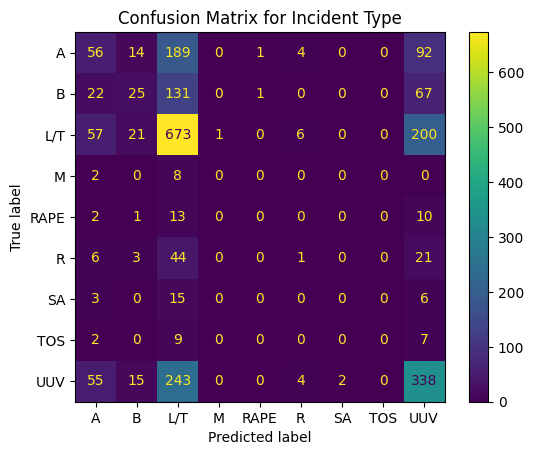

In [16]:
cm = confusion_matrix(y_test, pred)

ConfusionMatrixDisplay(cm,display_labels=["A", "B", "L/T", "M", "RAPE", "R", "SA", "TOS", "UUV"]).plot()
plt.title('Confusion Matrix for Incident Type')
plt.show()

### Performance Metrics

In [17]:
print(classification_report(y_test,pred,zero_division=np.nan))

                   precision    recall  f1-score   support

          ASSAULT       0.27      0.16      0.20       356
         BURGLARY       0.32      0.10      0.15       246
    LARCENY/THEFT       0.51      0.70      0.59       958
           MURDER       0.00      0.00       nan        10
             RAPE       0.00      0.00       nan        26
          ROBBERY       0.07      0.01      0.02        75
     SEXUAL ABUSE       0.00      0.00       nan        24
THEFT OF SERVICES        nan      0.00       nan        18
              UUV       0.46      0.51      0.48       657

         accuracy                           0.46      2370
        macro avg       0.20      0.17      0.29      2370
     weighted avg       0.41      0.46      0.43      2370



### KNN Classifier
The K-Nearest Neighbors Classifier uses the k nearest points to determine the output class by majority voting. The data will be normalized to prevent some predictors appearing larger than others. Cross-validation is used to select the value of k.

Text(0, 0.5, 'Accuracy Score')

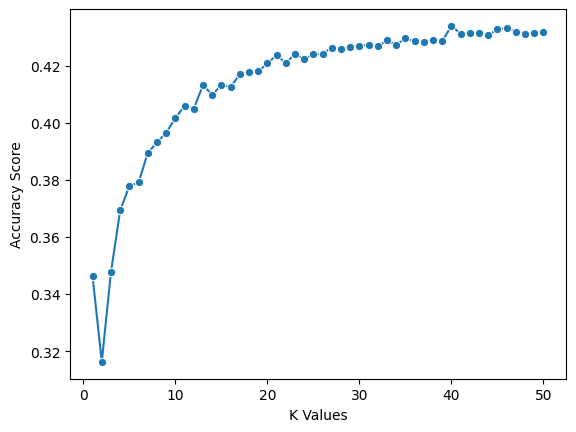

In [18]:
X = df_2023.drop(['Incident_Type', 'Neighborhood', 'Zip_Code', 'Year'], axis = 1)
y = df_2023['Incident_Type']

scores = []
scaler = StandardScaler()
X = scaler.fit_transform(X)

k_values = range(1, 51)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

The best k is 40
Its accuracy is 0.4339870657027392


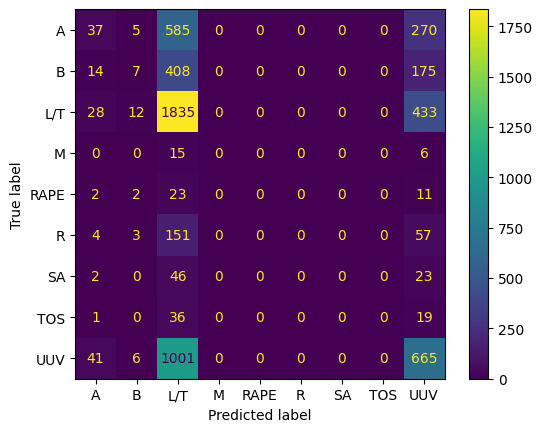

In [30]:
max_k = scores.index(max(scores)) + 1
max_score = max(scores)

print(f"The best k is {max_k}")
print(f"Its accuracy is {max(scores)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

knn = KNeighborsClassifier(n_neighbors = max_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

labels = ["ASSAULT", "BURGLARY", "LARCENY/THEFT", "MURDER", "RAPE", "ROBBERY", "SEXUAL ABUSE", "THEFT OF SERVICES", "UUV"]

cm = confusion_matrix(y_test, y_pred, labels = labels)
disp = ConfusionMatrixDisplay(cm, display_labels = ["A", "B", "L/T", "M", "RAPE", "R", "SA", "TOS", "UUV"])
disp.plot()

In [31]:
print(classification_report(y_test,y_pred,zero_division=np.nan))

                   precision    recall  f1-score   support

          ASSAULT       0.29      0.04      0.07       897
         BURGLARY       0.20      0.01      0.02       604
    LARCENY/THEFT       0.45      0.80      0.57      2308
           MURDER        nan      0.00       nan        21
             RAPE        nan      0.00       nan        38
          ROBBERY        nan      0.00       nan       215
     SEXUAL ABUSE        nan      0.00       nan        71
THEFT OF SERVICES        nan      0.00       nan        56
              UUV       0.40      0.39      0.39      1713

         accuracy                           0.43      5923
        macro avg       0.33      0.14      0.27      5923
     weighted avg       0.38      0.43      0.38      5923



## Conclusion
- Our models had low cross validation accuracy, which was caused by the LARCENY/THEFT class dominating the dataset
- However, looking at the number of incidents in total does provide insight as to which areas and times are safer 
- Future improvements to our model could include 
    - Feature selection using best subset selection
    - Hyperparameter tuning
    - Using more than only 2023 data

### Summary of Models
- Used cross validation to select the appropriate parameters for the models
- Then, used a training and test set to determine performance metrics


- Random Forests:
    - The accuracy was 46% using 81 trees
    - The precision was 41% using a weighted average
    - The recall was 46%
    - The f1 score was 43%
- Random Forest provides a feature importance ranking, indicating `Day`, `Hour`, `Latitude`, and `Longitude` are most important and `Neighborhood` and `ZIP_Code` are least important.

- KNN:
    - The accuracy was 43% using 40 neighbors
    - The precision was 33% using a weighted average
    - The recall was 43%
    - The f1 score was 38%

In [ ]:
normalized_conn.close()
non_normalized_conn.close()